# Demo notebook for generating simple plots from Bonsai/Harp nwb files

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO

nwb_folder = '/root/capsule/data/foraging_nwb_bonsai_harp'

Some util funcs

In [2]:
def moving_average(a, n=3) :
    ret = np.nancumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    
def plot_session_lightweight(data,   # choice_history, reward_history, p_reward
                             fitted_data=None, 
                             photostim=None,    # trial, power, s_type
                             valid_range=None,
                             smooth_factor=5, 
                             base_color='y', 
                             ax=None, 
                             vertical=False):
    # sns.reset_orig()
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 3) if not vertical else (3, 12), dpi=200)
        plt.subplots_adjust(left=0.1, right=0.8, bottom=0.05, top=0.8)

    if not vertical:
        gs = ax._subplotspec.subgridspec(2, 1, height_ratios=[1, 0.2], hspace=0.1)
        ax_1 = ax.get_figure().add_subplot(gs[0, 0])
        ax_2 = ax.get_figure().add_subplot(gs[1, 0])
        ax_1.get_shared_x_axes().join(ax_1, ax_2)
    else:
        gs = ax._subplotspec.subgridspec(1, 2, width_ratios=[0.2, 1], wspace=0.1)
        ax_1 = ax.get_figure().add_subplot(gs[0, 1])
        ax_2 = ax.get_figure().add_subplot(gs[0, 0])
        ax_1.get_shared_y_axes().join(ax_1, ax_2)
        
    with sns.plotting_context("notebook", font_scale=1):

        choice_history, reward_history, p_reward = data

        # == Fetch data ==
        n_trials = np.shape(choice_history)[1]

        p_reward_fraction = p_reward[1, :] / (np.sum(p_reward, axis=0))

        ignored_trials = np.isnan(choice_history[0])
        rewarded_trials = np.any(reward_history, axis=0)
        unrewarded_trials = np.logical_not(np.logical_or(rewarded_trials, ignored_trials))

        # == Choice trace ==
        # Rewarded trials
        xx = np.nonzero(rewarded_trials)[0] + 1
        yy = 0.5 + (choice_history[0, rewarded_trials] - 0.5) * 1.4
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)], 
                '|' if not vertical else '_', color='black', markersize=10, markeredgewidth=2)

        # Unrewarded trials
        xx = np.nonzero(unrewarded_trials)[0] + 1
        yy = 0.5 + (choice_history[0, unrewarded_trials] - 0.5) * 1.4
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                '|' if not vertical else '_', color='gray', markersize=6, markeredgewidth=1)

        # Ignored trials
        xx = np.nonzero(ignored_trials)[0] + 1
        yy = [1.1] * sum(ignored_trials)
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                'x', color='red', markersize=2, markeredgewidth=0.5, label='ignored')

        # Base probability
        xx = np.arange(0, n_trials) + 1
        yy = p_reward_fraction
        ax_1.plot(*(xx, yy) if not vertical else [*(yy, xx)],
                color=base_color, label='base rew. prob.', lw=1.5)

        # Smoothed choice history
        y = moving_average(choice_history, smooth_factor) / moving_average(~np.isnan(choice_history), smooth_factor)
        x = np.arange(0, len(y)) + int(smooth_factor / 2) + 1
        ax_1.plot(*(x, y) if not vertical else [*(y, x)],
                linewidth=1.5, color='black', label='choice (smooth = %g)' % smooth_factor)
        
        # finished ratio
        if np.sum(np.isnan(choice_history)):
            x = np.arange(0, len(y)) + int(smooth_factor / 2) + 1
            y = moving_average(~np.isnan(choice_history), smooth_factor)
            ax_1.plot(*(x, y) if not vertical else [*(y, x)],
                    linewidth=0.8, color='m', alpha=1,
                    label='finished (smooth = %g)' % smooth_factor)
             
        # add valid ranage
        if valid_range is not None:
            add_range = ax_1.axhline if vertical else ax_1.axvline
            add_range(valid_range[0], color='m', ls='--', lw=1, label='motivation good')
            add_range(valid_range[1], color='m', ls='--', lw=1)
                
        # For each session, if any fitted_data
        if fitted_data is not None:
            ax_1.plot(np.arange(0, n_trials), fitted_data[1, :], linewidth=1.5, label='model')
        
        # == photo stim ==
        if photostim is not None:
            plot_spec_photostim = { 'after iti start': 'cyan',  
                                    'before go cue': 'cyan',
                                    'after go cue': 'green',
                                    'whole trial': 'blue'}
            
            trial, power, s_type = photostim
            x = trial
            y = np.ones_like(trial) + 0.4
            scatter = ax_1.scatter(
                                *(x, y) if not vertical else [*(y, x)],
                                s=power.astype(float)*2,
                                edgecolors=[plot_spec_photostim[t] for t in s_type]
                                  if any(s_type) else 'darkcyan',
                                marker='v' if not vertical else '<',
                                facecolors='none',
                                linewidth=0.5,
                                label='photostim')

        # p_reward    
        xx = np.arange(0, n_trials) + 1
        ll = p_reward[0, :]
        rr = p_reward[1, :]
        ax_2.plot(*(xx, rr) if not vertical else [*(rr, xx)],
                color='b', label='p_right', lw=1)
        ax_2.plot(*(xx, ll) if not vertical else [*(ll, xx)],
                color='r', label='p_left', lw=1)
        ax_2.legend(fontsize=5, ncol=1, loc='upper left', bbox_to_anchor=(0, 1))
        
        if not vertical:
            ax_1.set_yticks([0, 1])
            ax_1.set_yticklabels(['Left', 'Right'])
            ax_1.legend(fontsize=6, loc='upper left', bbox_to_anchor=(0.6, 1.3), ncol=2)
            ax_1.set_xticks([])

            sns.despine(trim=True, bottom=True, ax=ax_1)
            sns.despine(trim=True, ax=ax_2)
        else:
            ax_1.set_xticks([0, 1])
            ax_1.set_xticklabels(['Left', 'Right'])
            ax_1.invert_yaxis()
            ax_1.legend(fontsize=6, loc='upper left', bbox_to_anchor=(0, 1.05), ncol=2)
            ax_1.set_yticks([])

            sns.despine(trim=True, left=True, ax=ax_1)
            sns.despine(trim=True, ax=ax_2)


        # ax_2.set(ylim=(0, 1))
    
    # ax.set_xlim(0,300)

    # fig.tight_layout()
    ax_2.set(xlabel='Trial number')
    ax.remove()

    return ax_1.get_figure(), [ax_1, ax_2]

## Load one session

In [3]:
nwb_file = '/LA30_2023-04-27.nwb'

io = NWBHDF5IO(nwb_folder + nwb_file, mode='r')
nwb = io.read()

In [4]:
nwb

root pynwb.file.NWBFile at 0x140134245516384
Fields:
  acquisition: {
    LeftLickTime <class 'pynwb.base.TimeSeries'>,
    LeftRewardDeliveryTime <class 'pynwb.base.TimeSeries'>,
    RightLickTime <class 'pynwb.base.TimeSeries'>,
    RightRewardDeliveryTime <class 'pynwb.base.TimeSeries'>
  }
  experiment_description: Optogenetics target brain areas:
  experimenter: ['']
  file_create_date: [datetime.datetime(2023, 5, 19, 14, 32, 41, 894490, tzinfo=tzoffset(None, -25200))]
  identifier: 86ceecae-2bec-47c3-a12c-cb1cc0f2b346
  institution: Allen Institute for Neural Dynamics
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  notes: day 6 training bonsai box with harp 
  protocol: Uncoupled Without Baiting
  related_publications: ['']
  session_description: Session end time:2023-04-27 12:54:07.975535  Give extra water(ml):0    Training tower:Tower-4
  session_id: LA30_2023-04-27.mat
  session_start_time: 2023-04-27 11:49:17.236535-07:00
  subject: subject pynwb.file.Subj

## Behavioral trials

In [22]:
df_trials = nwb.trials.to_dataframe()
df_trials['trial'] = df_trials.index + 1 # Add an one-based trial number column
df_trials

,start_time,stop_time,AnimalResponse,RewardedHistoryL,RewardedHistoryR,DelayStartTime,GoCueStartTime,RewardOutcomeTime,BaitLeft,BaitRight,...,LaserConditionPro,LaserStart,LaserStartOffset,LaserEnd,LaserEndOffset,LaserProtocol,LaserFrequency,LaserRampingDown,LaserPulseDur,trial
id,,,,,,,,,,,,,,,,,,,,,
0,1277797.625,1277803.625,0.0,0,0,1277801.750,1277802.375,1277802.625,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1277803.625,1277807.000,0.0,1,0,1277804.875,1277805.875,1277806.000,1,1,...,0,0,0,0,0,0,0,0,0,2
2,1277807.000,1277811.125,0.0,0,0,1277809.500,1277810.000,1277810.125,0,0,...,0,0,0,0,0,0,0,0,0,3
3,1277811.125,1277819.875,1.0,0,0,1277812.375,1277818.875,1277818.875,0,0,...,0,0,0,0,0,0,0,0,0,4
4,1277820.000,1277823.125,0.0,0,0,1277821.250,1277821.875,1277822.125,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,1281662.500,1281669.500,2.0,0,0,1281665.375,1281666.500,1281668.500,0,1,...,0,0,0,0,0,0,0,0,0,679
679,1281669.500,1281674.500,2.0,0,0,1281670.875,1281671.500,1281673.500,0,0,...,0,0,0,0,0,0,0,0,0,680
680,1281674.625,1281681.125,2.0,0,0,1281677.000,1281678.125,1281680.125,0,1,...,0,0,0,0,0,0,0,0,0,681


In [23]:
df_trials.columns

Index(['start_time', 'stop_time', 'AnimalResponse', 'RewardedHistoryL',
       'RewardedHistoryR', 'DelayStartTime', 'GoCueStartTime',
       'RewardOutcomeTime', 'BaitLeft', 'BaitRight',
       'BaseRewardProbabilitySum', 'RewardProbabilityL', 'RewardProbabilityR',
       'LeftValveOpenTime', 'RightValveOpenTime', 'BlockBeta', 'BlockMin',
       'BlockMax', 'MinRewardEachBlock', 'DelayBeta', 'DelayMin', 'DelayMax',
       'DelayDuration', 'ITIBeta', 'ITIMin', 'ITIMax', 'ITIDuration',
       'ResponseDuration', 'RewardConsumptionDuration', 'AutoWater',
       'LaserOnTrial', 'LaserWavelength', 'LaserLocation', 'LaserPower',
       'LaserDuration', 'LaserCondition', 'LaserConditionPro', 'LaserStart',
       'LaserStartOffset', 'LaserEnd', 'LaserEndOffset', 'LaserProtocol',
       'LaserFrequency', 'LaserRampingDown', 'LaserPulseDur', 'trial'],
      dtype='object')

In [13]:
nwb.trials.AnimalResponse.description

'The response of the animal. 0, left choice; 1, right choice; 2, no response'

### Trial view

<ipython-input-2-9eb85deb0729>:24: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax_1.get_shared_x_axes().join(ax_1, ax_2)
<ipython-input-2-9eb85deb0729>:70: RuntimeWarning: invalid value encountered in divide
  y = moving_average(choice_history, smooth_factor) / moving_average(~np.isnan(choice_history), smooth_factor)


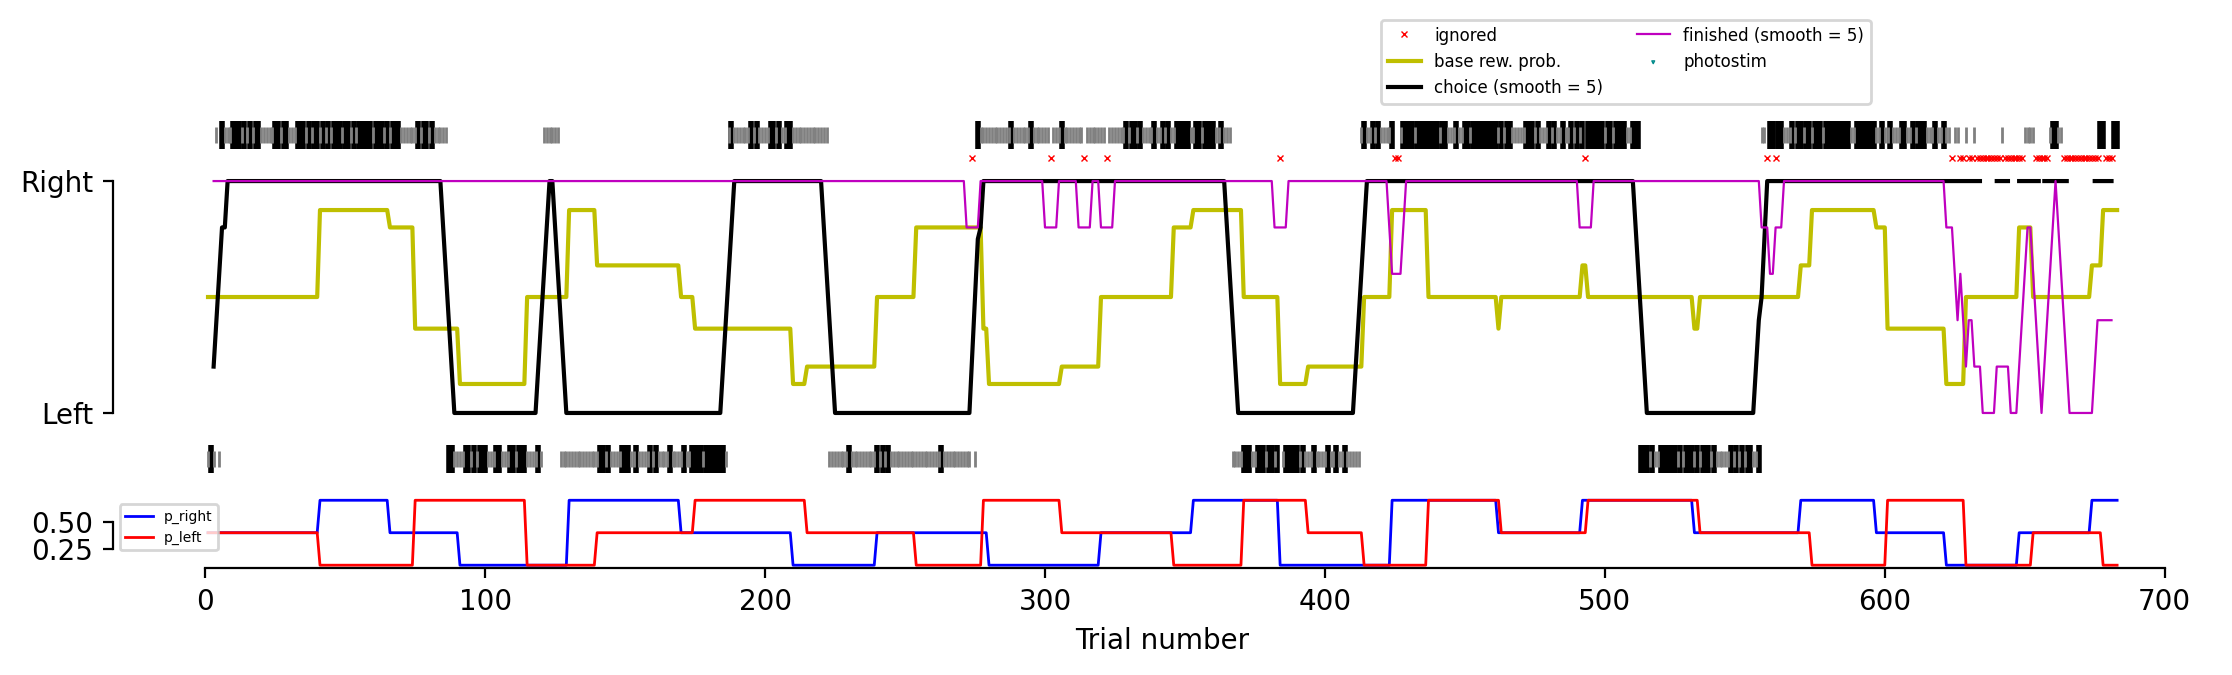

In [24]:
# Reformat data
choice_history = df_trials.AnimalResponse.map({0: 0, 1: 1, 2: np.nan}).values
reward_history = np.vstack([df_trials.RewardedHistoryL, df_trials.RewardedHistoryR])
p_reward = np.vstack([df_trials.RewardProbabilityL, df_trials.RewardProbabilityR])

# photostim
photostim_trials = df_trials.LaserPower > 0
photostim = [df_trials.trial[photostim_trials], df_trials.LaserPower[photostim_trials], []]

# Plot session
fig, ax = plot_session_lightweight([np.array([choice_history]), reward_history, p_reward], photostim=photostim)

## Behavioral events

#### Here is the trial structure

1. In the inter-trial-interval (ITI), lickports are far from the mice.
2. (Some sessions) at the trial start, lickports move forward to the "ready" position (`lickportready`, ephys only)
3. A "no-lick period" starts (relatively short in my experiments, ~0.2-0.5 sec)
4. In the "no-lick period", if there is a "early lick", add a 2 sec timeout, and go back to `3` (still in the same trial)
5. If there is no early lick, deliver a `go_cue` sound, and a "response window" starts (typically 5 sec)
6. If there is any lick in the response window:
    <br>i. The first lick after the go cue is considered as `choice`. Deliver reward if a reward exists on the chosen lickport ("hit"), otherwise, "miss"
   <br>ii. If there is no more lick in any 1-second window, go to `8`. (In other words, if the mouse keeps licking, the trial will become very long)
   <br>iii. If there is any lick to the other lickport than the "choice", this trial is "double-dipped". In part of experiments, the trial will be terminated (go to `8`) to discourage double-dipping.
7. If there is no lick in the response window, this trial is an "ignore" trial, and go to `8`.
8. `trialend`: lickports are retracted and IT starts.## Behavioral trials

Time stamps stored in `df_trial`

In [ ]:
[t for t in df_trials.columns if 'time' in t.lower()]

['start_time',
 'stop_time',
 'DelayStartTime',
 'GoCueStartTime',
 'RewardOutcomeTime',
 'LeftValveOpenTime',
 'RightValveOpenTime']

Get the session start time

In [35]:
t0 = df_trials.start_time[0]

Note that the "RewardOutcomeTime" is not accurate in `df_trial`. We should use the one in `nwb.acquisition`.

In [29]:
nwb.acquisition.keys()

dict_keys(['LeftLickTime', 'LeftRewardDeliveryTime', 'RightLickTime', 'RightRewardDeliveryTime'])

For example, get all go cue times (all times are relative to the first trial start of a session, in sec)

In [57]:
t_go_cue = df_trials.GoCueStartTime - t0
t_trial_end = df_trials.stop_time - t0
key_from_acq = ['LeftLickTime', 'RightLickTime', 'LeftRewardDeliveryTime', 'RightRewardDeliveryTime']
t_from_acq = {key: nwb.acquisition[key].data[:] - t0 for key in key_from_acq}

## Time view

In [85]:
event_color_map = {'go': 'green',
                #    'choice': 'm', 
                   'right_lick': 'blue', 
                   'left_lick': 'red', 
                   'reward': 'cyan', 
                   'trialend': 'black'}
event_times = [t_go_cue, 
               t_from_acq['RightLickTime'], 
               t_from_acq['LeftLickTime'], 
               np.hstack([t_from_acq['LeftRewardDeliveryTime'], t_from_acq['RightRewardDeliveryTime']]),
               t_trial_end,
               ]
               

# fig, ax = plt.subplots(1, 1, figsize=(20, 3))
# ax.eventplot(event_times, colors=list(event_color_map.values()), linelengths=0.6, lineoffsets=-1)
# ax.legend(event_color_map)
# ax.set_xlim((0, 20))
# ax.set(xlabel='Time (sec)')

In [93]:
import plotly.graph_objects as go

fig = go.Figure()

for n, event in enumerate(event_color_map.keys()):
    fig.add_trace(go.Scatter(
                            x=event_times[n],
                            y=np.full_like(event_times[n], 10 - n),
                            mode='markers',
                            marker=dict(symbol='line-ns',
                                        size=15,
                                        line_width=2,
                                        line_color=event_color_map[event],
                                        ),
                            name=event,
                            ))

# Set layout
fig.update_layout(
    xaxis=dict(title='Time (sec)'),
    yaxis=dict(showticklabels=False)
)

# Show the plot
fig.show()